# Reparameterizing the Weibull Accelerated Failure Time Model

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import patsy
import theano.tensor as tt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


## Dataset

The [previous example notebook on Bayesian parametric survival analysis](https://docs.pymc.io/notebooks/bayes_param_survival.html) introduced two different accelerated failure time (AFT) models: Weibull and log-linear. In this notebook, we present three different parameterizations of the Weibull AFT model.

The data set we'll use is the `flchain` R data set, which comes from a medical study investigating the effect of serum free light chain (FLC) on lifespan. Read the full documentation of the data by running:

`print(statsmodels.datasets.get_rdataset(package='survival', dataname='flchain').__doc__)`.

In [2]:
# Fetch and clean data
data = (statsmodels.datasets
                   .get_rdataset(package='survival', dataname='flchain')
                   .data
                   .sample(500)  # Limit ourselves to 500 observations
                   .reset_index(drop=True))

In [3]:
y = data.futime.values
censored = ~data['death'].values.astype(bool)

In [4]:
y[:5]

array([4997, 3563, 4774, 4347, 4642])

In [5]:
censored[:5]

array([ True,  True,  True,  True,  True])

## Using `pm.Potential`

We have an unique problem when modelling censored data. Strictly speaking, we don't have any _data_ for censored values: we only know the _number_ of values that were censored. How can we include this information in our model?

One way do this is by making use of `pm.Potential`. The [PyMC2 docs](https://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class) explain its usage very well. Essentially, declaring `pm.Potential('x', logp)` will add `logp` to the log-likelihood of the model.

## Parameterization 1

This parameterization is an intuitive, straightforward parameterization of the Weibull survival function. This is probably the first parameterization to come to one's mind.

In [6]:
def weibull_lccdf(x, alpha, beta):
    ''' Log complementary cdf of Weibull distribution. '''
    return -(x / beta)**alpha

In [7]:
with pm.Model() as model_1:
    alpha_sd = 10.0

    mu = pm.Normal('mu', mu=0, sd=100)
    alpha_raw = pm.Normal('a0', mu=0, sd=0.1)
    alpha = pm.Deterministic('alpha', tt.exp(alpha_sd * alpha_raw))
    beta = pm.Deterministic('beta', tt.exp(mu / alpha))
    
    y_obs = pm.Weibull('y_obs', alpha=alpha, beta=beta, observed=y[~censored])
    y_cens = pm.Potential('y_cens', weibull_lccdf(y[censored], alpha, beta))

In [8]:
with model_1:
    # Increase tune and change init to avoid divergences
    trace_1 = pm.sample(draws=1000, tune=1000,
                        nuts_kwargs={'target_accept': 0.9},
                        init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 715.11draws/s]
The number of effective samples is smaller than 25% for some parameters.


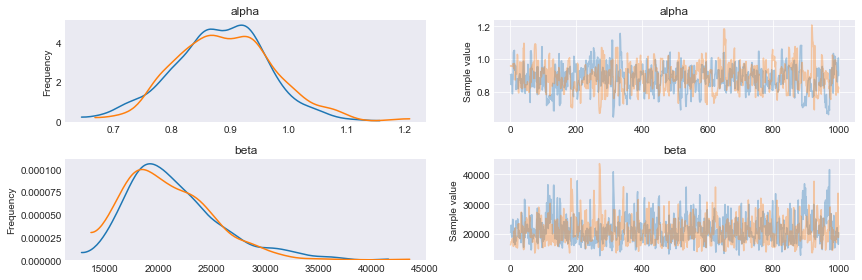

In [9]:
pm.traceplot(trace_1, varnames=['alpha', 'beta']);

In [10]:
pm.summary(trace_1, varnames=['alpha', 'beta']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.89,0.08,0.0,0.71,1.04,430.86,1.0
beta,21279.47,4329.62,165.8,14604.80,30455.07,539.37,1.0


## Parameterization 2

Note that, confusingly, `alpha` is now called `r`, and `alpha` denotes a prior; we maintain this notation to stay faithful to the original implementation in Stan. In this parameterization, we still model the same parameters `alpha` (now `r`) and `beta`.

For more information, see [this Stan example model](https://github.com/stan-dev/example-models/blob/5e9c5055dcea78ad756a6fb9b3ff9a77a0a4c22b/bugs_examples/vol1/kidney/kidney.stan) and [the corresponding documentation](https://www.mrc-bsu.cam.ac.uk/wp-content/uploads/WinBUGS_Vol1.pdf).

In [11]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    r = pm.Gamma('r', alpha=1, beta=0.001, testval=0.25)
    beta = pm.Deterministic('beta', tt.exp(-alpha / r))

    y_obs = pm.Weibull('y_obs', alpha=r, beta=beta, observed=y[~censored])
    y_cens = pm.Potential('y_cens', weibull_lccdf(y[censored], r, beta))

In [12]:
with model_2:
    # Increase tune and target_accept to avoid divergences
    trace_2 = pm.sample(draws=1000, tune=1000,
                        nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 679.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


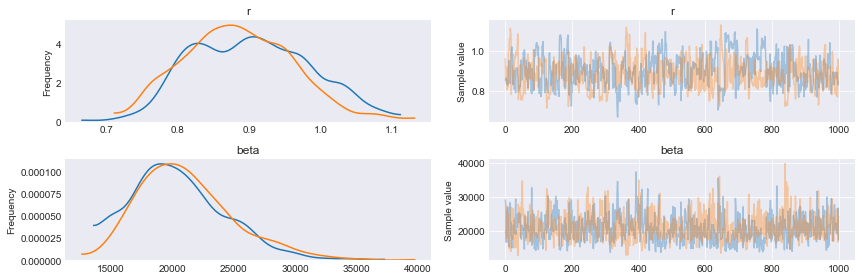

In [13]:
pm.traceplot(trace_2, varnames=['r', 'beta']);

In [14]:
pm.summary(trace_2, varnames=['r', 'beta']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
r,0.89,0.08,0.00,0.74,1.04,292.68,1.01
beta,20837.43,3882.68,170.03,14144.94,28628.50,403.01,1.00


## Parameterization 3

In this parameterization, we model the log-linear error distribution with a Gumbel distribution instead of modelling the survival function directly. For more information, see [this blog post](http://austinrochford.com/posts/2017-10-02-bayes-param-survival.html).

In [15]:
logtime = np.log(y)

def gumbel_sf(y, mu, sigma):
    ''' Gumbel survival function. '''
    return 1.0 - tt.exp(-tt.exp(-(y - mu) / sigma))

In [16]:
with pm.Model() as model_3:
    s = pm.HalfNormal('s', tau=5.0)
    gamma = pm.Normal('gamma', mu=0, sd=5)

    y_obs = pm.Gumbel('y_obs', mu=gamma, beta=s, observed=logtime[~censored])
    y_cens = pm.Potential('y_cens', gumbel_sf(y=logtime[censored], mu=gamma, sigma=s))

In [17]:
with model_3:
    # Increase tune and change init to avoid divergences
    trace_3 = pm.sample(draws=1000, tune=1000,
                        init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gamma, s]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1994.07draws/s]


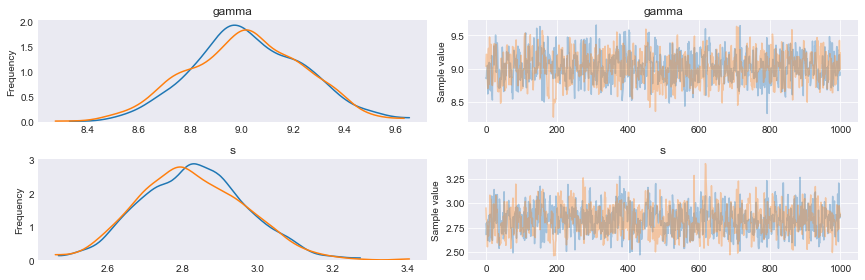

In [18]:
pm.traceplot(trace_3);

In [19]:
pm.summary(trace_3).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
gamma,9.02,0.22,0.01,8.59,9.42,871.31,1.0
s,2.83,0.14,0.00,2.58,3.12,879.94,1.0


## Authors

- Originally collated by [Junpeng Lao](https://junpenglao.xyz/) on Apr 21, 2018. See original code [here](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/65447fdb431c78b15fbeaef51b8c059f46c9e8d6/PyMC3QnA/discourse_1107.ipynb).
- Authored and ported to Jupyter notebook by [George Ho](https://eigenfoo.xyz/) on Jul 15, 2018.